# Constitutive modelling using JuliaFEM

Author(s): Jukka Aho

**Abstract**: This is reproduction of the results from notebook [*Ideal plastic Von Mises material*](https://github.com/JuliaFEM/JuliaFEM.jl/blob/master/notebooks/2015-09-24-Ideal%20plastic%20Von%20Mises%20material.ipynb) made by Olli Väinölä. Small strain theory is used, see https://en.wikipedia.org/wiki/Flow_plasticity_theory. The purpose of this notebook is to show how one can easily design and simulate material models using JuliaFEM.

In [1]:
using JuliaFEM: IntegrationPoint, Field, FieldSet, TimeStep, Increment
using ForwardDiff
using PyPlot

The atomic structure here is `IntegrationPoint`. It has identical `Field`-structure like elements and can store multidimensional variables which can be time-dependent also. That way one can easily store, for example, measured strain and easily run material simulation for measured data.

In [2]:
ip = IntegrationPoint([0.0, 0.0], 1.0)

ip.fields["total strain"] = Field()
ip.fields["plastic strain"] = Field()
ip.fields["plastic potential"] = Field()
ip.fields["elastic strain"] = Field()
ip.fields["effective plastic strain"] = Field()
ip.fields["stress"] = Field()
ip.fields["young"] = Field(200.0e9)
ip.fields["poisson"] = Field(0.3)
ip.fields["yield stress"] = Field(200.0e6)
ip.fields["plastic rate parameter"] = Field() # material parameter

JuliaFEM.DefaultDiscreteField(JuliaFEM.TimeStep[])

Accessing parameters is done just like with `FieldSet`s in general:

In [3]:
info(last(ip.fields["young"]))
info(last(ip.fields["yield stress"]))

INFO: [2.0e11]
INFO: [2.0e8]


Our material model is

In [2]:
""" Ideal plastic material model. """
function calculate_stress!(ip::IntegrationPoint, strain::Matrix, time::Number)

    poisson = last(ip.fields["poisson"])[1]
    young = last(ip.fields["young"])[1]
    mu = young/(2*(1+poisson))
    lambda = young*poisson/((1+poisson)*(1-2*poisson))

    # yield function
    function f(stress)
        stress_dev = stress - 1/3*trace(stress)*I  # stress deviator tensor
        stress_v = sqrt(3/2*trace(stress_dev*stress_dev')) # equivalent tensile stress
        stress_y = last(ip.fields["yield stress"])[1]
        return stress_v - stress_y
    end

    stress_trial = lambda*trace(strain)*I + 2*mu*strain

    if f(stress_trial) <= 0.0
        info("time=$time: no yield")
        push!(ip.fields["stress"], TimeStep(time, Increment(Matrix[stress_trial])))
        push!(ip.fields["total strain"], TimeStep(time, Increment(Matrix[strain])))
        return true
    else
        info("time=$time: yield, f(stress_trial) = $(f(stress_trial))")
        dt = time - ip.fields["total strain"][end].time

        # associated flow rule, plastic potential ψ(σ) = f
        psi = f

        """ Calculate equations

            dσ - C (dϵₜ - dγ*dΨ/dσ) = 0
                         σₑ(σ) - σy = 0

            dϵₜ = total strain
            dϵₑ = elastic strain
            dϵₚ = plastic strain
        
            dϵₜ = dϵₑ + dϵₚ
            => dϵₑ = dϵₜ - dϵₚ = dϵₜ - dγ*dψ/dσ
            dσ = λ⋅tr(dϵₑ)I + 2μ⋅dϵₑ
            => dσ - λ⋅tr(dϵₑ)I - 2μ⋅dϵₑ = 0
        """
        function residual(params::Vector)
            stress = reshape(params[1:9], 3, 3)
            gamma = params[end]

            strain_prev = last(ip.fields["total strain"])[1]
            stress_prev = last(ip.fields["stress"])[1]

            dstrain_total = 1/dt*(strain - strain_prev)
            #dstress = 1/dt*(stress - stress_prev)
            dstress = 1/dt*(stress_trial - stress)
            # derivative of plastic potential ψ(σ) w.r.t 2nd order tensor σ(ϵ)
            # https://en.wikipedia.org/wiki/Tensor_derivative_%28continuum_mechanics%29
            # "Derivatives of scalar valued functions of second-order tensors"
            dpsi_dstress = derivative(psi, stress)
            dstrain_plastic = gamma*dpsi_dstress
            dstrain_elastic = dstrain_total - dstrain_plastic
            dstress_elastic = lambda*trace(dstrain_elastic)*I + 2*mu*dstrain_elastic

            stress_delta = dstress - dstress_elastic
            return [vec(stress_delta); psi(stress)]
        end

        
        # solve equations using Newton iterations. Jacobian is calcualated
        # using automatic differentiation as usual.
        params = [vec(stress_trial); 0.0]
        for i=1:5
            A = ForwardDiff.jacobian(residual, params)
            b = -residual(params)
            dparams = A \ b
            params += dparams
            norm(dparams) < 1.0e-7 && break
        end
        stress = reshape(params[1:9], 3, 3)
        push!(ip.fields["stress"], TimeStep(time, Increment(Matrix[stress])))
        push!(ip.fields["total strain"], TimeStep(time, Increment(Matrix[strain])))
    end

end    ### END OF CONSTITUTIVE MODEL

calculate_stress! (generic function with 1 method)

Small "simulator" to study the behavior of material model in `IntegrationPoint`

In [3]:
function run(steps=3)

    # initialization
    ip = IntegrationPoint([0.0, 0.0], 1.0)
    ip.fields["total strain"] = Field()
    ip.fields["plastic strain"] = Field()
    ip.fields["plastic potential"] = Field()
    ip.fields["elastic strain"] = Field()
    ip.fields["effective plastic strain"] = Field()
    ip.fields["stress"] = Field()
    ip.fields["young"] = Field(200.0e9)
    ip.fields["poisson"] = Field(0.3)
    ip.fields["yield stress"] = Field(200.0e6)
    ip.fields["plastic rate parameter"] = Field() # material parameter

    # run
    for (time, strain_11) in enumerate(linspace(0, 200e-5, steps))
        # set up strain etc.
        time = Float64(time)
        poisson = last(ip.fields["poisson"])[1]
        strain = zeros(3, 3)
        strain[1, 1] = strain_11
        strain[2, 2] = -poisson*strain_11
        strain[3, 3] = -poisson*strain_11

        # calculate stress
        calculate_stress!(ip, strain, time)
    end

    return ip
end

ip = run();

INFO: time=1.0: no yield
INFO: time=2.0: no yield
INFO: time=3.0: yield, f(stress_trial) = 2.0e8


Visualize results:

INFO: [0.0 200.00000000000003 200.00000000000006]
INFO: [0.0 1000.0 2000.0]


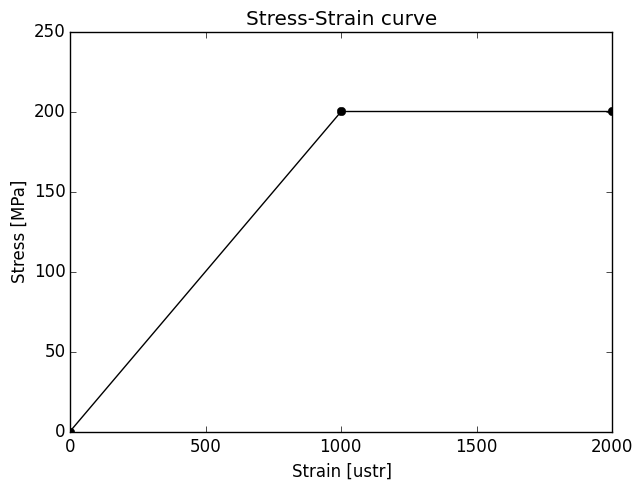

In [4]:
function plot_stress_strain_curve(ip)
    steps = length(ip.fields["total strain"])
    eps11 = zeros(steps)
    sig11 = zeros(steps)
    for i=1:steps
        # extract from integration points -- too complicated
        # field -> timestep -> increment -> (vector of tensors, take first) -> (first component)
        eps11[i] = ip.fields["total strain"][i][end][1][1,1]
        sig11[i] = ip.fields["stress"][i][end][1][1,1]
    end
    eps11 *= 1.0e6
    sig11 *= 1.0e-6

    PyPlot.figure(figsize=(7, 5))
    PyPlot.plot(eps11, sig11, "-ko")
    PyPlot.title("Stress-Strain curve")
    PyPlot.xlabel("Strain [ustr]")
    PyPlot.ylabel("Stress [MPa]")
    PyPlot.ylim([0, 250])
    info(sig11')
    info(eps11')
end

plot_stress_strain_curve(ip)